In [ ]:
!pip install -U langgraph langsmith
!pip install -U "langchain[google-genai]"
!pip install -U langchain-core langchain-community langchain-tavily wikipedia ddgs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 6.1 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=3ae44487e46c2fa641de3aec72b7b816a4327519ade5cbb4b206fdc9c987c06b
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [218]:
import os
from duckduckgo_search import DDGS
from langchain_tavily import TavilySearch
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchRun
from langchain_core.tools import tool

class SearchTools:
    def __init__(self, max_docs = 3):
        os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
        self.max_docs = max_docs

    def search_tavily(self, query: str):
        """Searches the internet, for the given query."""
        try:
            tavily_search = TavilySearch(max_results=self.max_docs)
            result = tavily_search.invoke(query)
            if not result:
                return None
            return result
        except Exception as e:
            print(f"Tavily Search Failed: {e}")
            return None

    def search_wikipedia(self, query: str):
        """Uses Wikipedia. An excellent source to search internet for factual information."""
        try:
            wikipedia = WikipediaAPIWrapper(top_k_results=self.max_docs, doc_content_chars_max=2000)
            result = wikipedia.run(query)
            return result
        except Exception as e:
            print(f"Wikipedia Search Failed: {e}")
            return None

    def search_duckduckgo(self, query: str):
        """Searches the internet, for the given query."""
        try:
            ddg_search = DuckDuckGoSearchRun()
            result = ddg_search.run(query)
            return result
        except Exception as e:
            print(f"DuckDuckGo Search Failed: {e}")
            return None


    def __call__(self, query: str) -> str:
        """A tool to search the internet for real-time information. Use this for questions about current events, weather, sports scores, or any topic that requires up-to-date information beyond the model's knowledge cutoff. The input should be a clear search query."""
        final_result = None
        final_result = self.search_tavily(query)
        if not final_result:
            final_result = self.search_wikipedia(query)
        if not final_result:
            final_result = self.search_duckduckgo(query)
        if final_result:
            return final_result
        else:
            return "No results found after trying all search methods."
search_internet_instance = SearchTools(max_docs=5)

@tool
def web_search(query: str) -> str:
    """A tool to search the internet for real-time information. The input should be a clear search query."""
    return search_internet_instance(query)

In [210]:
tools = [web_search]

In [213]:
import os
from langchain.chat_models import init_chat_model
from google.colab import userdata
from langchain_core.messages import SystemMessage

os.environ["GOOGLE_API_KEY"] = userdata.get('GEMINI_API_KEY')

llm = init_chat_model("google_genai:gemini-2.5-flash")
llm_with_tools = llm.bind_tools(tools)

In [214]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

agent = create_react_agent(
    model=llm,
    tools=tools
)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        response = agent.invoke({"messages": [HumanMessage(content=user_input)]})
        if response and "messages" in response and response["messages"]:
             response["messages"][-1].pretty_print()
        else:
            print("Agent did not return a response.")
    except Exception as e:
        print(f"An error occurred: {e}")
        break

User: What is elon musks net worth
================================== Ai Message ==================================

Elon Musk's net worth fluctuates. According to Forbes, as of December 2nd, 2024, his net worth is estimated to be $230.1 billion.


KeyboardInterrupt: Interrupted by user

In [151]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [152]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [153]:
import json
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import ToolMessage

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [154]:
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()
graph = graph_builder.compile()

In [155]:
config = {"configurable": {"thread_id": "1"}}

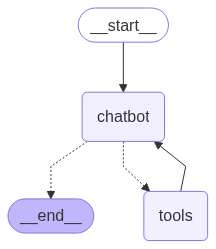

In [156]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    eventss = graph.stream({"messages": [{"role": "user", "content": user_input}]}, config, stream_mode = "values")
    last_event = None
    for event in eventss:
        last_event = event
    if last_event:
        last_event["messages"][-1].pretty_print()

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break